In [1]:
## lifetime data in water

In [166]:
%matplotlib ipympl

import os
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from onix.data_tools import get_experiment_data
from onix.helpers import data_identifier, console_bold, present_float
from onix.units import ureg, Q_
from onix.analysis.fitter import Fitter

import pickle

In [77]:
def exp_decay(t, tau, a, c):
    return np.exp(-t / tau) * a + c

In [78]:
class FluorescenceDecay:
    def __init__(self, data_signal):
        self._data_signal = data_signal
        self._excitation_time = self._data_signal[1]["excitation_time"].to("s").magnitude
        if "frequency" in self._data_signal[1]:
            self.freq = self._data_signal[1]["frequency"]
        else:
            self.freq = None
        try:
            self.normalizer = self._data_signal[1]["normalizer"]
        except KeyError:
            self.normalizer = None
        self._excitation_delay = self._data_signal[1]["excitation_delay"].to("s").magnitude
        self._test_time = self._data_signal[1]["test_time"].to("s").magnitude
        self._average_data()
        
    def _average_data(self):
        self._times = self._data_signal[0]["pmt_times"]
        self.times_ms = self._times * 1e3
        signal_voltages = self._data_signal[0]["pmt_voltages"]
        self.V_signal_avg = np.average(signal_voltages, axis=0)
        self.V_signal_err = np.std(signal_voltages, axis=0) / np.sqrt(len(signal_voltages))
    
    def get_test_data(self, offset_time=100e-6):
        test_start_time = offset_time * 2
        test_end_time = offset_time * 2 + self._test_time + self._excitation_delay * 2
        test_mask = np.bitwise_and(
            self._times > test_start_time,
            self._times <= test_end_time,
        )
        self._test_end = test_end_time + offset_time
        self.test_times_ms = self.times_ms[test_mask]
        self.V_signal_test_avg = self.V_signal_avg[test_mask]
        self.V_signal_test_err = self.V_signal_err[test_mask]

    def get_decay_data(self):
        decay_start_time = self._test_end + self._excitation_delay * 2 + self._excitation_time
        decay_mask = self._times > decay_start_time
        decay_start_time_ms = decay_start_time * 1e3
        self.decay_times_ms = self.times_ms[decay_mask] - decay_start_time_ms
        self.V_signal_decay_avg = self.V_signal_avg[decay_mask]
        self.V_signal_decay_err = self.V_signal_err[decay_mask]

In [163]:
def data_from_dnum(data_number: int, default_excitation_time_ms = 5, default_excitation_delay_us = 10, default_test_time_us = 10):
    raw_data = get_experiment_data(data_number)
    if "excitation_time" not in raw_data[1]:
        raw_data[1]["excitation_time"] = default_excitation_time_ms * ureg.ms
        print(f"excitation_time in data #{data_number} is set to {raw_data[1]['excitation_time']}.")
    if "excitation_delay" not in raw_data[1]:
        raw_data[1]["excitation_delay"] = default_excitation_delay_us * ureg.us
        print(f"excitation_delay in data #{data_number} is set to {raw_data[1]['excitation_delay']}.")
    if "test_time" not in raw_data[1]:
        raw_data[1]["test_time"] = default_test_time_us * ureg.us
        print(f"test_time in data #{data_number} is set to {raw_data[1]['test_time']}.")
    data = FluorescenceDecay(raw_data)
    identifier = "data " + data_identifier([data_number])
    return data, identifier

def plot_three_panel(data, identifier):
    fig, axs = plt.subplots(2, 3, figsize=(12, 8), gridspec_kw={"width_ratios": [2, 2, 4], "height_ratios": [3, 1]})
    axs[0][0].errorbar(data.times_ms, data.V_signal_avg, data.V_signal_err, label="signal")
    axs[0][0].set_xlabel("time (ms)")
    axs[0][0].set_ylabel("PMT voltage (V)")
    axs[0][0].legend()

    data.get_test_data()
    axs[0][1].errorbar(data.test_times_ms, data.V_signal_test_avg, data.V_signal_test_err, label="signal test")
    axs[0][1].set_xlabel("time (ms)")
    axs[0][1].set_ylabel("PMT voltage (V)")
    axs[0][1].legend()

    data.get_decay_data()
    fitter = Fitter(exp_decay)
    fitter.set_data(data.decay_times_ms, data.V_signal_decay_avg, data.V_signal_decay_err)
    fitter.set_p0({"tau": 0.1, "a": 10, "c": 0})
    fitter.fit()
    
    axs[0][2].errorbar(data.decay_times_ms, data.V_signal_decay_avg, data.V_signal_decay_err, label="data")
    axs[0][2].plot(data.decay_times_ms, fitter.fitted_value(data.decay_times_ms), label="fit", zorder=50)
    axs[0][2].text(0.2, 0.5, fitter.all_results_str(), transform=axs[0][2].transAxes)
    axs[0][2].legend()
    axs[0][2].set_ylabel("PMT voltage (V)")
    
    axs[1][2].scatter(data.decay_times_ms, fitter.studentized_residuals(), s=5)
    axs[1][2].set_xlim(*axs[0][2].get_xlim())
    axs[1][2].use_sticky_edges = True
    axs[1][2].hlines([-3, -2, -1, 0, 1, 2, 3], *ax1.get_xlim(), zorder=0, color="grey", linewidth=0.5)
    axs[1][2].use_sticky_edges = False
    
    axs[1][2].set_xlabel("time (ms)")
    axs[1][2].set_ylabel("Studentized residuals")
    ax.set_ylabel("PMT voltage (V)")

    plt.tight_layout()
    plt.show()

In [164]:
data_numbers = {
    "3.5 M": 195,
    "3.11 M": 214,
    "2.8 M": 218,
    "2.33 M": 221,
    "2 M": 224,
    "1.75 M": 229,
    "1.4 M": 325,
    "1.08 M": 327,
    "0.78 M": 356,
    "0.61 M": 383,
}

In [174]:
with open("all_lifetime_water_data.pickle", "wb") as f:
    pickle.dump(all_data, f)

3.5 M


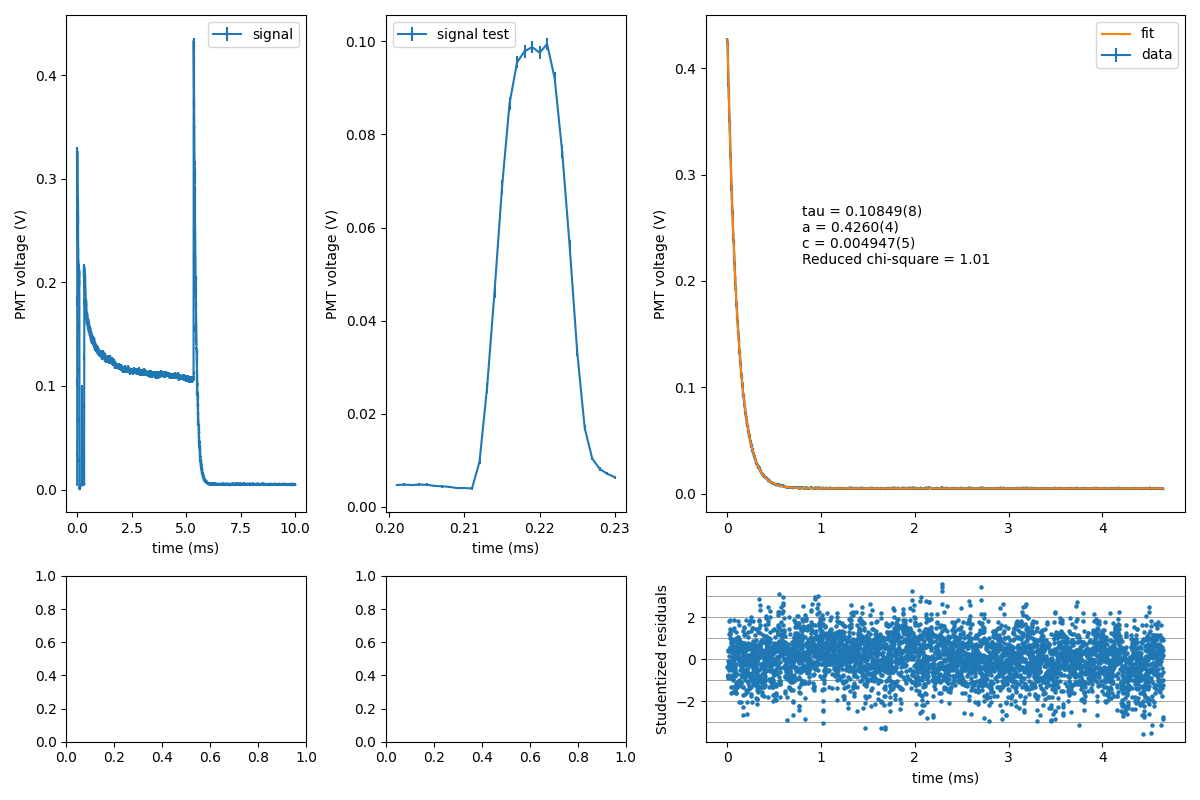

3.11 M


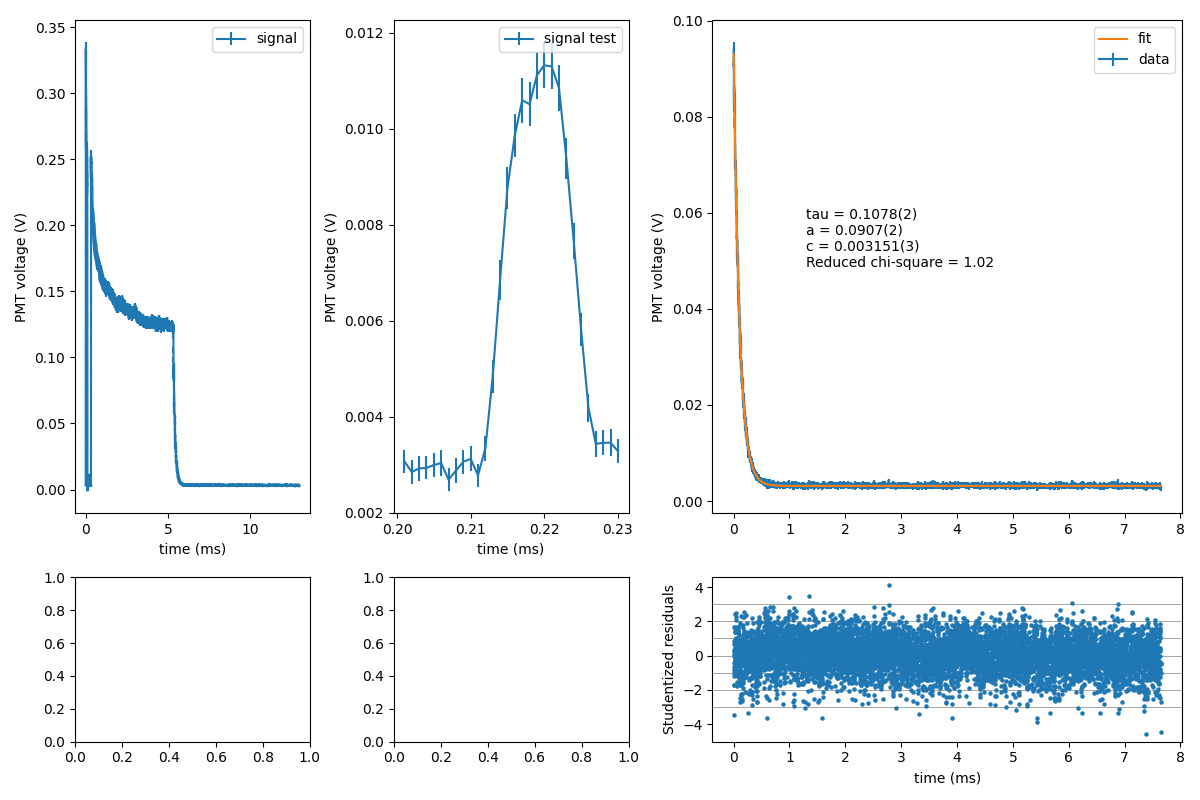

2.8 M


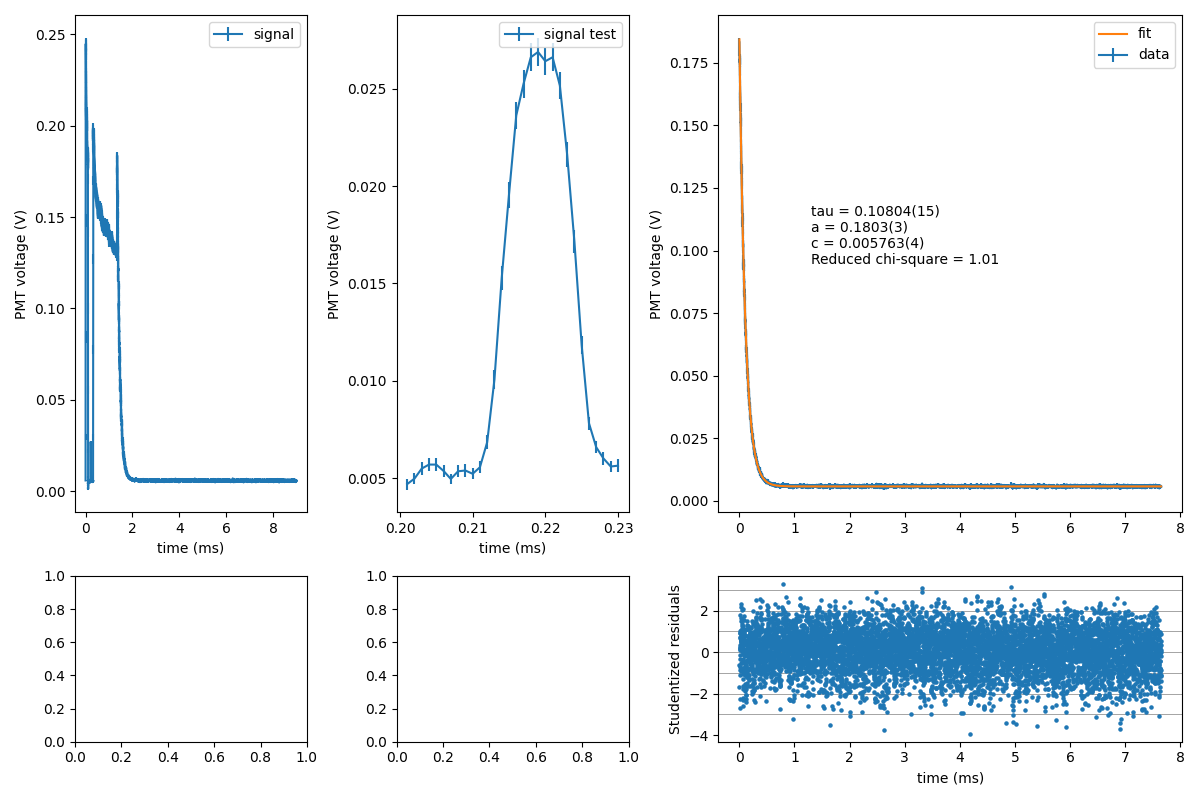

2.33 M


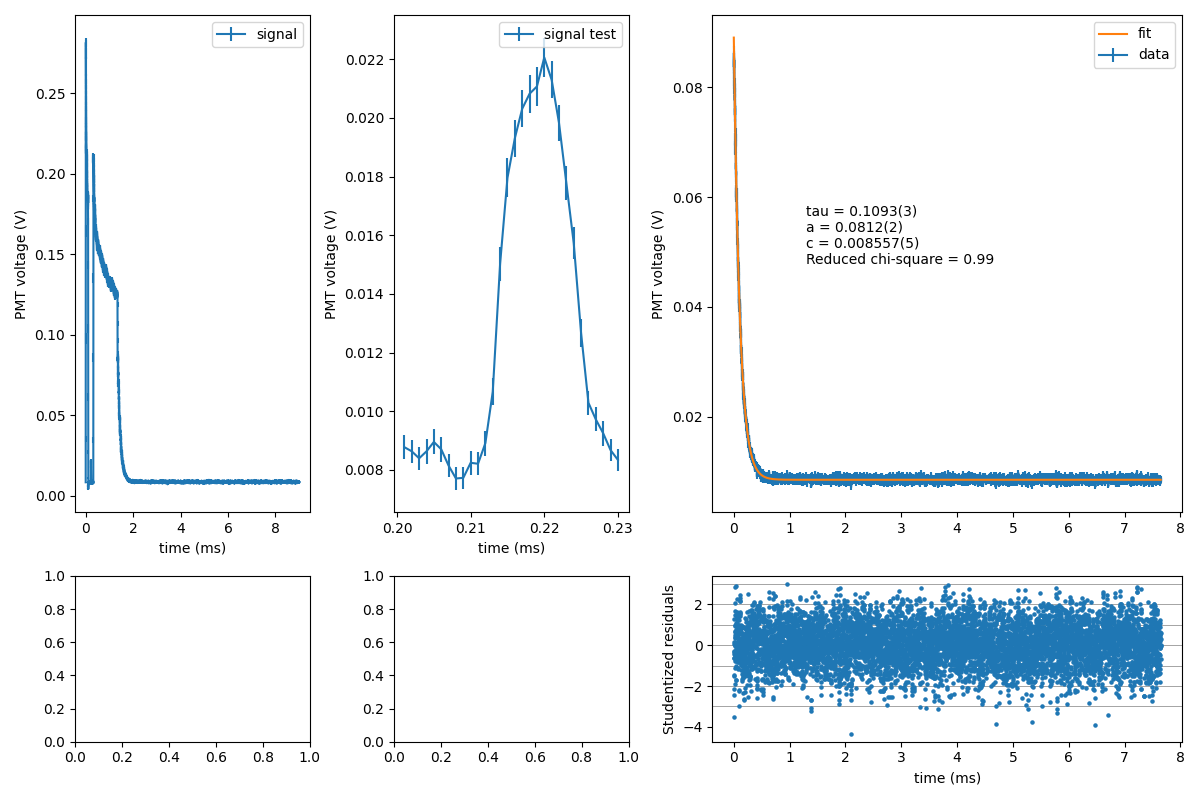

2 M


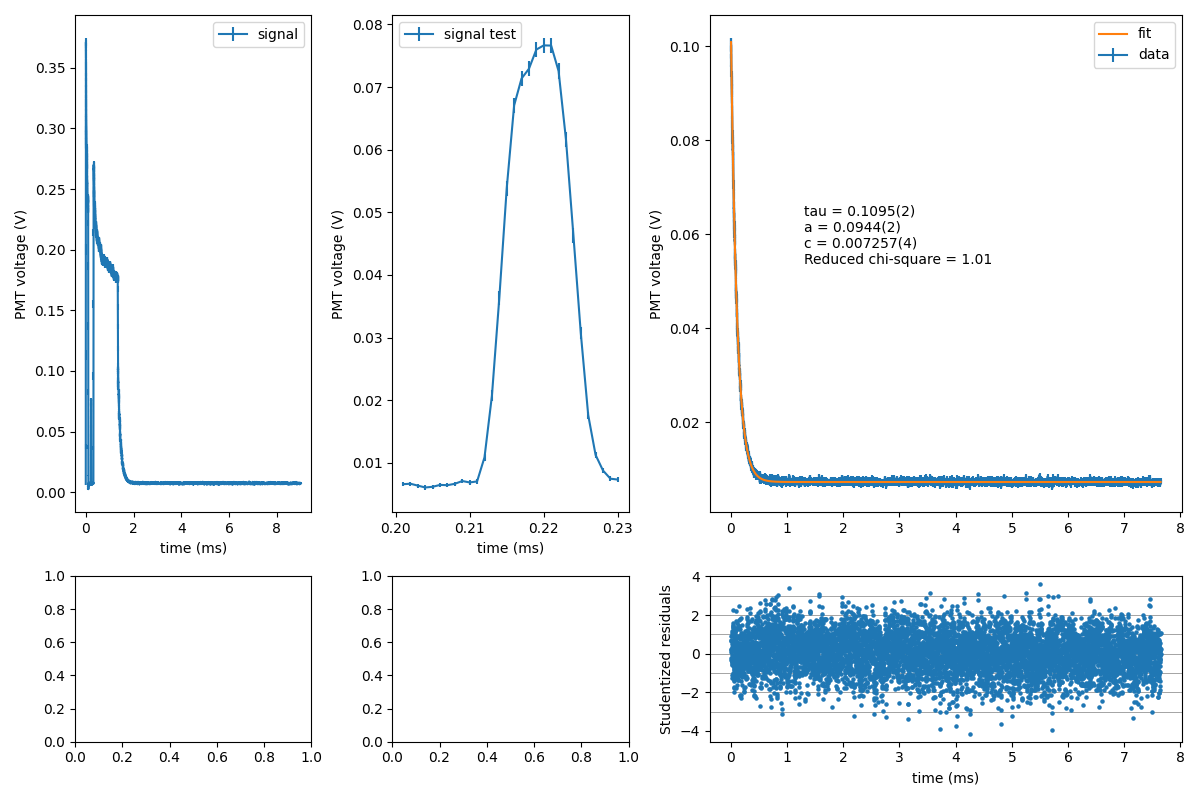

1.75 M


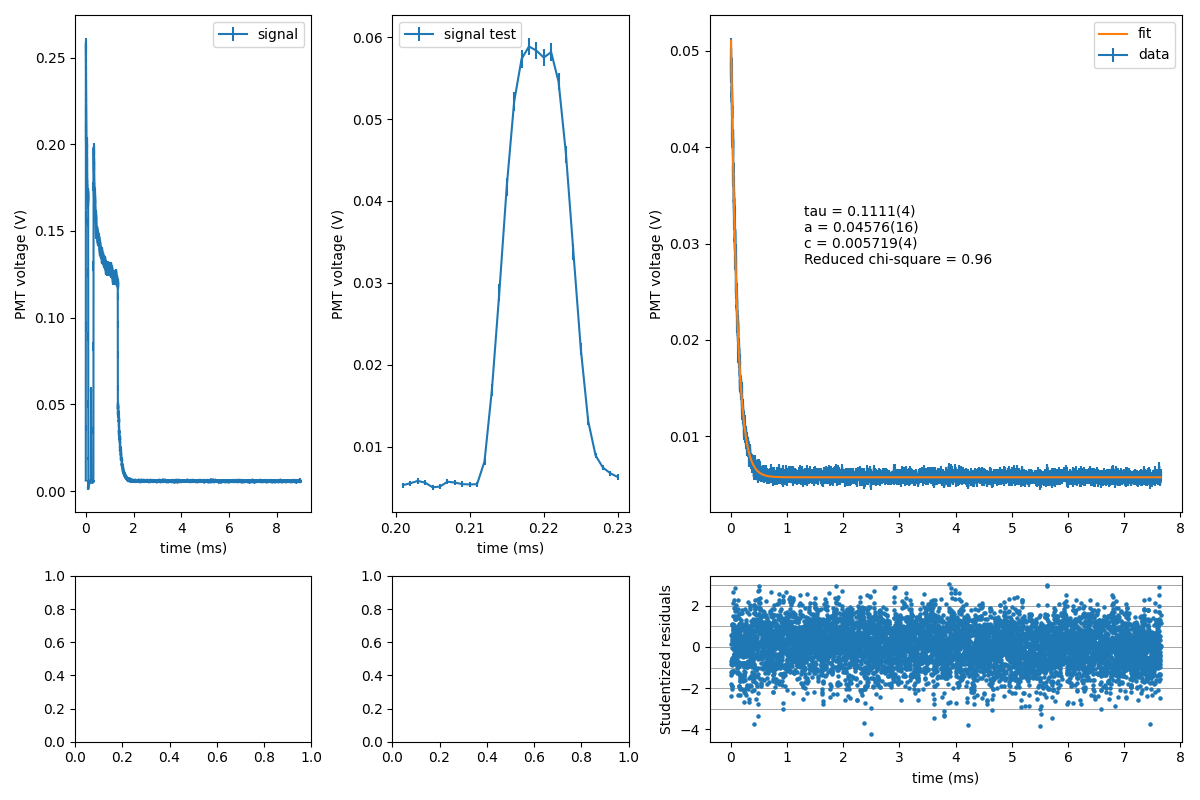

1.4 M


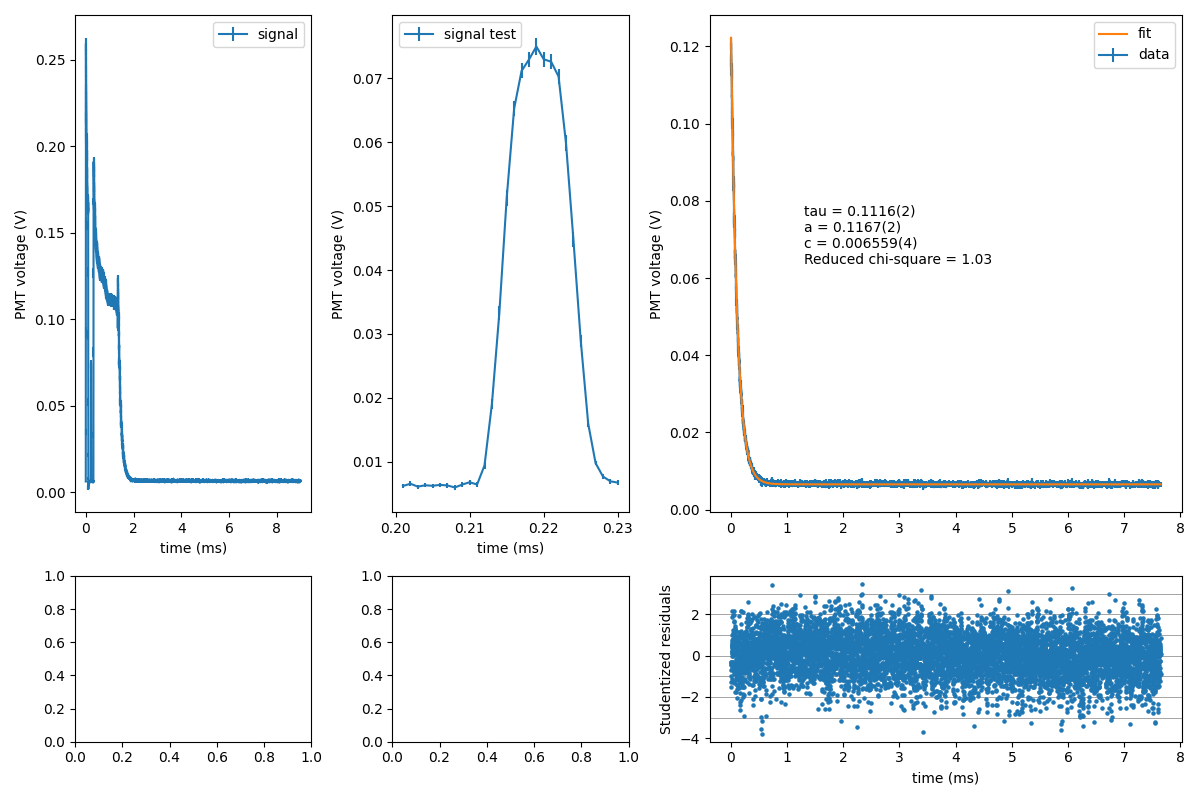

1.08 M


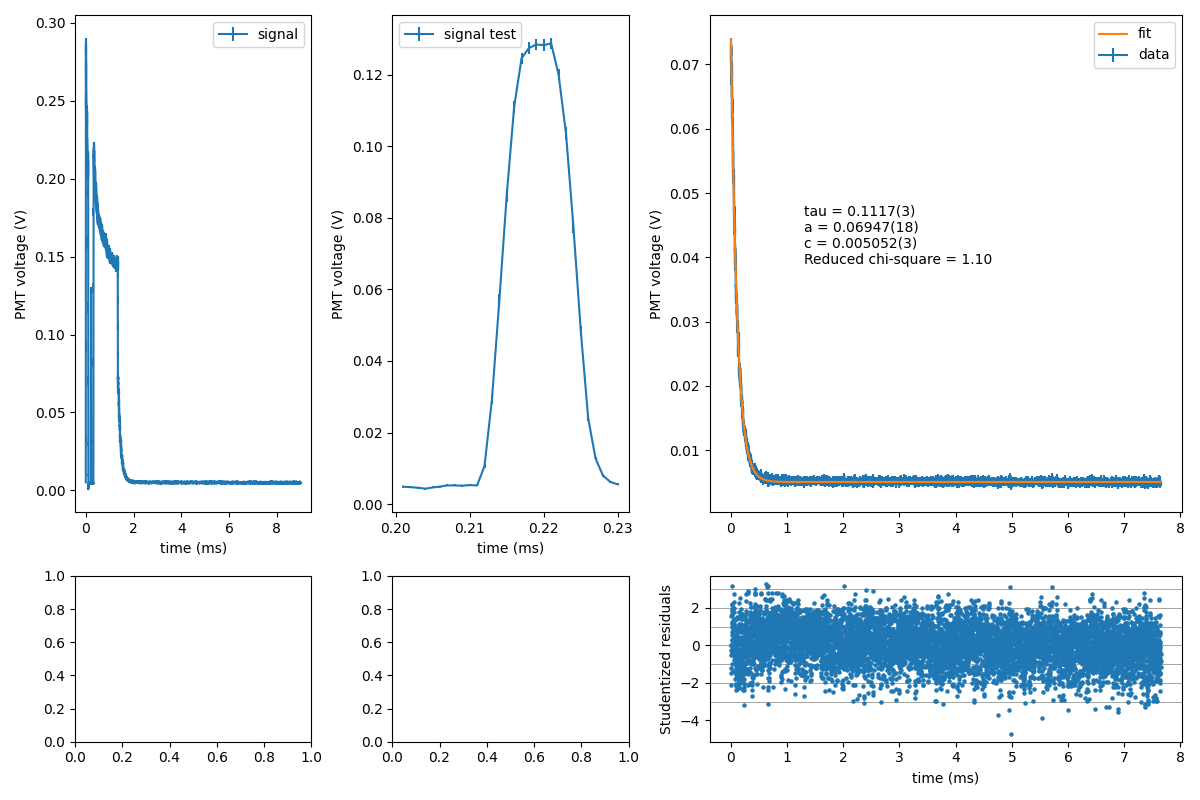

0.78 M


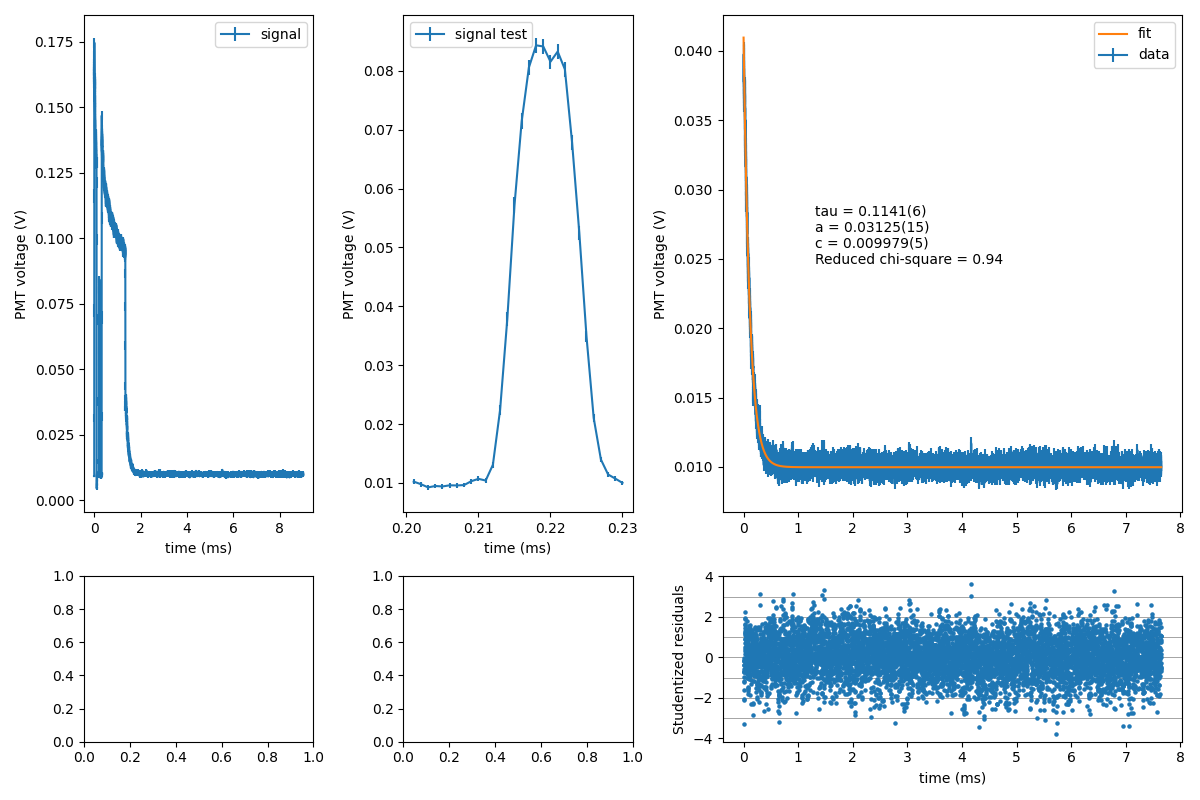

0.61 M


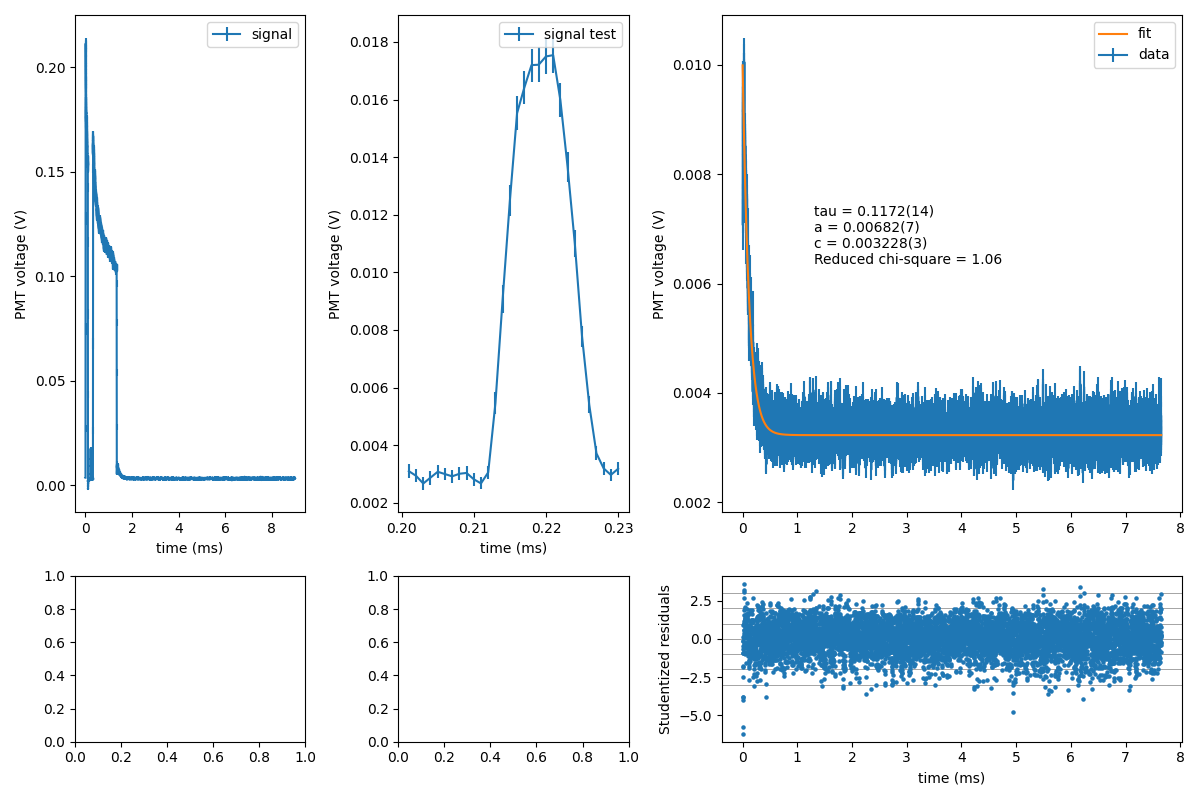

In [175]:
all_data = {}
try:
    with open("all_lifetime_water_data.pickle", "rb") as f:
        all_data = pickle.load(f)
except Exception as e:
    print("load all data from vault")
    for concentration in data_numbers:
        all_data[concentration] = data_from_dnum(data_numbers[concentration])
for concentration in all_data:
    print(concentration)
    plot_three_panel(*all_data[concentration])